In [8]:
from __future__ import print_function
import pandas as pd
import numpy as np
import sys
sys.path.append('/storage/pipelines/')
import kang

**gff 파일 입력**

In [2]:
#basedir = '../aha_v2_final.gff3'
file_gff = '../aha_v2_final.gff3'


In [5]:
df_gff = pd.read_csv(file_gff,sep='\t',header=None,comment='#')

In [6]:
mask = (df_gff[2]=='mRNA')
df_gff = df_gff[mask]

In [6]:
def get_genename(query):
    dic = dict(zip([x.split('=')[0] for x in query.split(';')],[x.split('=')[1] for x in query.split(';')]))
    return(dic['Name'])

In [9]:
df_gff['transcriptname'] = df_gff[8].apply(lambda x : kang.infoparse(x)['ID'])

In [10]:
df_gff_ix = df_gff.set_index('transcriptname')

In [14]:
df_gff_ix.head()

,0,1,2,3,4,5,6,7,8
transcriptname,,,,,,,,,
mRNA1,scaffold-399,AUGUSTUS,mRNA,111,394,0.21,-,.,ID=mRNA1;Parent=gene1
mRNA2,scaffold-399,maker,mRNA,752,1880,.,-,.,ID=mRNA2;Parent=gene2;Name=Aha0399s00010.2;Ali...
mRNA3,scaffold-399,maker,mRNA,752,2740,.,-,.,ID=mRNA3;Parent=gene2;Name=Aha0399s00010.1;Ali...
mRNA4,scaffold-399,AUGUSTUS,mRNA,909,1421,0.94,-,.,ID=mRNA4;Parent=gene2;Name=g45869.t1
mRNA5,scaffold-399,maker,mRNA,1805,2740,.,-,.,ID=mRNA5;Parent=gene2;Name=Aha0399s00010.3;Ali...


**mcscan output 입력**

In [11]:
file_kaks = './Ah2Ah.collinearity.kaks'
df_kaks = pd.read_csv(file_kaks,sep='\t',header=None,comment='#')

In [12]:
df_kaks['synteny_ID'] = df_kaks[0].apply(lambda x:x.strip().split('-')[0]) 

In [17]:
df_kaks['ChrA'] = df_kaks[1].apply(lambda x : df_gff_ix.xs(x)[0])
df_kaks['ChrB'] = df_kaks[2].apply(lambda x : df_gff_ix.xs(x)[0])

In [21]:
df_kaks['PosA'] = df_kaks[1].apply(lambda x : df_gff_ix.xs(x)[3])
df_kaks['PosB'] = df_kaks[2].apply(lambda x : df_gff_ix.xs(x)[3])

In [22]:
df_kaks_sbix = df_kaks.set_index('synteny_ID')

In [101]:
df_kaks_sbix.xs('337')

,0,1,2,3,4,5,ChrA,ChrB,PosA,PosB
synteny_ID,,,,,,,,,,
337,337- 0:,mRNA44804,mRNA70890,3.000000e-97,0.010679,0.033246,scaffold-36,scaffold-948,2803485,759
337,337- 1:,mRNA44805,mRNA70891,1.000000e-31,0.032614,0.039483,scaffold-36,scaffold-948,2803636,902
337,337- 2:,mRNA44806,mRNA70897,1.000000e-72,0.026482,0.013334,scaffold-36,scaffold-948,2805083,1450
337,337- 3:,mRNA44807,mRNA70900,4.000000e-76,0.029292,0.016664,scaffold-36,scaffold-948,2805083,28775
337,337- 4:,mRNA44808,mRNA70901,7.000000e-144,0.000000,0.000000,scaffold-36,scaffold-948,2806121,31252
337,337- 5:,mRNA44811,mRNA70909,0.000000e+00,0.001512,0.001388,scaffold-36,scaffold-948,2812208,41307


**첫 synteny ID**

In [97]:
synteny_ID = '337'
edf = df_kaks_sbix.xs(synteny_ID)

chr_a = edf['ChrA'].values[0]
chr_b = edf['ChrB'].values[0]
pos_a = edf['PosA'].values
pos_b = edf['PosB'].values
mRNA_a = edf[1].values
mRNA_b = edf[2].values

m1 = df_gff[0] == chr_a
m2 = np.min(pos_a) <= df_gff[3].astype(np.int)
m3 = df_gff[3].astype(np.int)<= np.max(pos_a)
mask = m1&m2&m3
transcriptlist_in_synteny_A = df_gff[mask]['transcriptname'].values

m1 = df_gff[0] == chr_b
m2 = np.min(pos_b) <= df_gff[3].astype(np.int)
m3 = df_gff[3].astype(np.int)<= np.max(pos_b)
mask = m1&m2&m3
transcriptlist_in_synteny_B = df_gff[mask]['transcriptname'].values

diameter = 5 # of the circle representing a gene
spacing = 3 # fixed distance between genes 
A_line_length = (diameter*2 + spacing) * len(transcriptlist_in_synteny_A)
B_line_length = (diameter*2 + spacing) * len(transcriptlist_in_synteny_B)

filename = 'synteny_ID_%s.svg'%synteny_ID
Outfile = open(filename,'w')
width   = A_line_length + 200
height  = 1000
gap     = 300 # gap between species lines

print('''<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<svg height="%s" width="%s" version="1.1" viewBox="0 0 %s %s" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">'''
      %(height,width,height,width),file=Outfile)



#line = '<line x1="%d" y1="%d" x2="%d" y2="%d" style="stroke:rgb(255,0,0);stroke-width:1" />' 
line = '<line x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />' 
dotline = '<line stroke-dasharray="2, 5" x1="%d" y1="%d" x2="%d" y2="%d" stroke="%s" stroke-width="1" />'
# left dot to right dot
circle = '<circle cx="%d" cy="%d" r="%d" stroke="black" stroke-width="1" fill="%s" fill-opacity="0.4"/>'
# x, y, diameter
text =  '<text x="%d" y="%d" fill="black">%s</text>'
# x, y, text

# Line! 가로줄
Alx = (width/2)-(A_line_length/2)
Aly = 20
Arx = (width/2)+(A_line_length/2)
Ary = 20
print(line%(Alx,Aly,Arx,Ary,'grey'),file=Outfile)
print(dotline%(Alx-20,Aly,Arx+20,Ary,'grey'),file=Outfile)
print(text%(Alx,Aly-10,chr_a),file=Outfile)

# Line! 가로줄
Blx = (width/2)-(B_line_length/2)
Bly = Aly + gap
Brx = (width/2)+(B_line_length/2)
Bry = Ary + gap
print(line%(Blx,Bly,Brx,Bry,'grey'),file=Outfile)
print(dotline%(Blx-20,Bly,Brx+20,Bry,'grey'),file=Outfile)
print(text%(Blx,Bly-10,chr_b),file=Outfile)

dicG2P_A = {} # genename to position
for i,j  in enumerate(transcriptlist_in_synteny_A):
    print(circle%(i*(spacing+diameter*2)+Alx,Aly,diameter,'white'),file=Outfile)
    dicG2P_A[j] = [i*(spacing+diameter*2)+Alx,Aly]

dicG2P_B = {}
for i,j  in enumerate(transcriptlist_in_synteny_B):
    print(circle%(i*(spacing+diameter*2)+Blx,Bly,diameter,'white'),file=Outfile)
    dicG2P_B[j] = [i*(spacing+diameter*2)+Blx,Bly]

for i,j in enumerate(mRNA_a):
    gnA = j
    gnB = mRNA_b[i]
    lx, ly = dicG2P_A[gnA]
    rx, ry = dicG2P_B[gnB]
    print(line%(lx,ly,rx,ry,'grey'),file=Outfile)
    print(circle%(lx,ly,diameter,'red'),file=Outfile)
    print(circle%(rx,ry,diameter,'red'),file=Outfile)

In [98]:
print('''</svg>

''',file=Outfile)

Outfile.close()

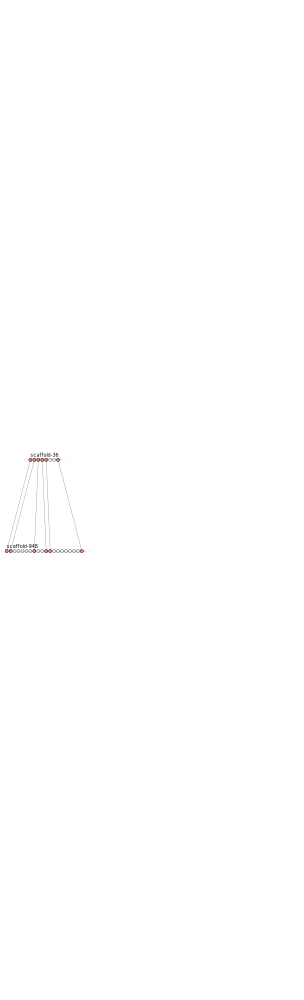

In [99]:
from IPython.display import SVG, display
display(SVG(filename))

**두번째 부터는 다음 펑션으로**

In [71]:
def add_synteny(ID,layer,start):
    synteny_ID = '337'
    edf = df_kaks_sbix.xs(synteny_ID)

    chr_a = edf['ChrA'].values[0]
    chr_b = edf['ChrB'].values[0]
    pos_a = edf['PosA'].values
    pos_b = edf['PosB'].values
    mRNA_a = edf[1].values
    mRNA_b = edf[2].values

    m1 = df_gff[0] == chr_a
    m2 = np.min(pos_a) <= df_gff[3].astype(np.int)
    m3 = df_gff[3].astype(np.int)<= np.max(pos_a)
    mask = m1&m2&m3
    transcriptlist_in_synteny_A = df_gff[mask]['transcriptname'].values

    m1 = df_gff[0] == chr_b
    m2 = np.min(pos_b) <= df_gff[3].astype(np.int)
    m3 = df_gff[3].astype(np.int)<= np.max(pos_b)
    mask = m1&m2&m3
    transcriptlist_in_synteny_B = df_gff[mask]['transcriptname'].values
   
    A_line_length = (diameter*2 + spacing) * len(transcriptlist_in_synteny_A)
    B_line_length = (diameter*2 + spacing) * len(transcriptlist_in_synteny_B)


    #height = 500
    gap = 300 # gap between species lines
    # Line! 
    Blx = start
    Bly = Aly + gap * layer
    Brx = start+B_line_length
    Bry = Ary + gap * layer
    print(line%(Blx,Bly,Brx,Bry,'grey'),file=Outfile)
    print(text%(Blx,Bly-10,B_chr+':'+str(B_pos[0])+'..'+str(B_pos[-1])),file=Outfile)

    dicG2P_A = {} # genename to position
    for i,j  in enumerate(transcriptlist_in_synteny_A):
        print(circle%(i*(spacing+diameter*2)+Alx,Aly,diameter,'white'),file=Outfile)
        dicG2P_A[j] = [i*(spacing+diameter*2)+Alx,Aly]
    
    dicG2P_B = {}
    for i,j  in enumerate(transcriptlist_in_synteny_B):
        print(circle%(i*(spacing+diameter*2)+Blx,Bly,diameter,'white'),file=Outfile)
        dicG2P_B[j] = [i*(spacing+diameter*2)+Blx,Bly]

    for i,j in enumerate(mRNA_a):
        gnA = j
        gnB = mRNA_b[i]
        lx, ly = dicG2P_A[gnA]
        rx, ry = dicG2P_B[gnB]
        print(line%(lx,ly,rx,ry,'grey'),file=Outfile)
        print(circle%(lx,ly,diameter,'red'),file=Outfile)
        print(circle%(rx,ry,diameter,'red'),file=Outfile)

In [289]:
add_synteny('51',2,width/4)
add_synteny('72',2,width/4-500)
add_synteny('78',3,width/5)
add_synteny('79',3,width/5+1000)


557
358
30
33
70
63
70
73
